# K-Nearest Neighbors

This model actually doesn't learn the fit function, it just understands how things looked in the past, e.g. if (3,4) had always given you 5 as the third side of the triangle, then (3.1, 3.9) should also give something around ~5 because the "nearest neighbors" have given that in the past. <br>

It is also called "lazy learning algorithm".

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import pandas as pd

import sys
import os

# Add the project root to sys.path (one level up from this notebook)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from hypotai.data import generate_triangle_data

In [3]:
df = generate_triangle_data(5)
df

,a,b,angle_deg,c
0,77.418209,97.564673,90.0,124.548964
1,43.943956,76.137856,90.0,87.909297
2,85.873932,78.627824,90.0,116.433101
3,69.767066,12.898552,90.0,70.949391
4,9.508317,45.093555,90.0,46.085104


Let's look at the a,b, and c values for 5 triangles. Then, let's imagine we want to "estimate" the `c` value for a triangle with sides `55,60` then what we can do is define "k-number of nearest neighbors". For simplicity, let's say `k=2` Then the nearest examples are the two nearest triangles, i.e. number 1 and 3. (Since data is created randomly, these can change.)

Text(0, 0.5, 'side b')

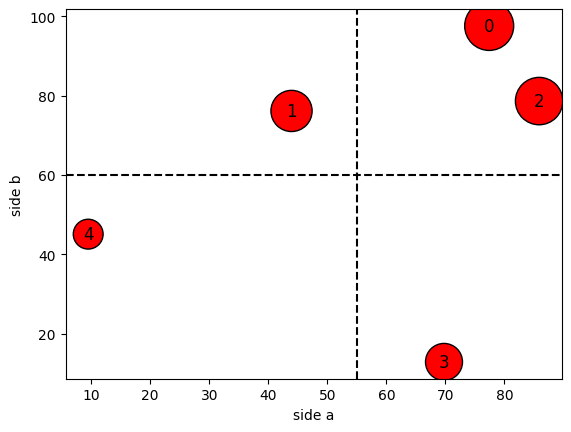

In [42]:
selected_data = (55, 60)
plt.scatter(df['a'], df['b'], c="r", s=df['c']*10, ec='k', )
plt.axvline(selected_data[0], color='k', linestyle='--')
plt.axhline(selected_data[1], color='k', linestyle='--')
for i, (x, y) in enumerate(zip(df['a'], df['b']), 0):
    plt.text(x, y, str(i), color='black', fontsize=12, ha='center', va='center')
plt.xlabel('side a')
plt.ylabel('side b')

In [43]:
## manually find the closest point
distances = np.sqrt((df['a'] - selected_data[0])**2 + (df['b'] - selected_data[1])**2)
closest_indices = np.argpartition(distances,1)
print(closest_indices)
df.iloc[closest_indices]

[1 2 0 4 3]


,a,b,angle_deg,c
1,43.943956,76.137856,90.0,87.909297
2,85.873932,78.627824,90.0,116.433101
0,77.418209,97.564673,90.0,124.548964
4,9.508317,45.093555,90.0,46.085104
3,69.767066,12.898552,90.0,70.949391


Then, following the logic, we take the average of the two closest results.

Predicted c: 102.17, Actual c: 81.39


Text(0, 0.5, 'side b')

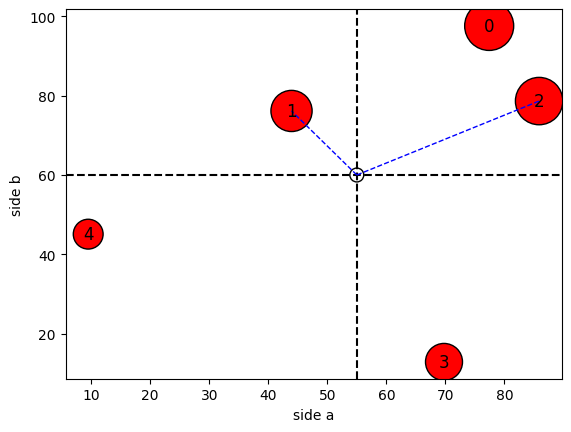

In [56]:
predicted_c = np.mean(df.iloc[closest_indices[:2]]['c'])
print(f"Predicted c: {predicted_c:.2f}, Actual c: {np.sqrt(selected_data[0]**2 + selected_data[1]**2):.2f}")

selected_data = (55, 60)
plt.scatter(df['a'], df['b'], c="r", s=df['c']*10, ec='k', )
plt.axvline(selected_data[0], color='k', linestyle='--')
plt.axhline(selected_data[1], color='k', linestyle='--')
for i, (x, y) in enumerate(zip(df['a'], df['b']), 0):
    plt.text(x, y, str(i), color='black', fontsize=12, ha='center', va='center')
plt.scatter(selected_data[0], selected_data[1], c='none', s=100, edgecolor='k', label='Selected Point')
# Plot lines from the selected point to its two nearest neighbors using a loop
for idx in closest_indices[:2]:
    plt.plot([selected_data[0], df.iloc[idx, 0]], [selected_data[1], df.iloc[idx, 1]], color='blue', linestyle='--', linewidth=1   )
plt.xlabel('side a')
plt.ylabel('side b')


## Now let's do the same using "Machine Learning" way. 

In [57]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [75]:
X_train, y_train = df[['a', 'b']], df['c']
X_test = pd.DataFrame({"a": [selected_data[0]], "b": [selected_data[1]]})
y_test = pd.DataFrame({"c": [np.sqrt(selected_data[0]**2 + selected_data[1]**2)]})

knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train, y_train)

,n_neighbors,2
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [76]:
knn_pred = knn.predict(X_test)
print(f"KNN Predicted c: {knn_pred[0]:.2f}")

KNN Predicted c: 102.17


Voila. It gives exactly what we already calculated. You can also average over more "neighbors" which might (or not) help. Now, let's do a large dataset.

### Large set.

In [82]:
df = generate_triangle_data(50_000)
X_train, X_test, y_train, y_test = train_test_split(df[['a', 'b']], df['c'], test_size=0.2, random_state=42)
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, knn_pred):.2f}")
print(f"R^2 Score: {r2_score(y_test, knn_pred):.2f}")

knn2 = KNeighborsRegressor(n_neighbors=6)
knn2.fit(X_train, y_train)
knn_pred2 = knn2.predict(X_test)

Mean Squared Error: 0.03
R^2 Score: 1.00


Text(0.5, 1.0, 'Distribution of Residuals')

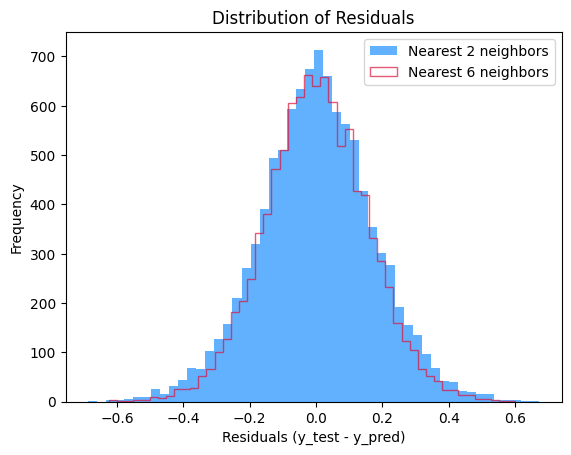

In [85]:
plt.hist(y_test-knn_pred, bins=50, color='dodgerblue', alpha=0.7, label='Nearest 2 neighbors', histtype='stepfilled');
plt.hist(y_test-knn_pred2, bins=50, color='crimson', alpha=0.7, label='Nearest 6 neighbors', histtype='step');
plt.legend()
plt.xlabel('Residuals (y_test - y_pred)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

Okay, for the 90-degree triangles increasing the neighbor size has a little effect. Let's see how this "algorithm" performs on random-angle triangles.

In [86]:
df_random = generate_triangle_data(50_000,angle_mode='random')
X_train, X_test, y_train, y_test = train_test_split(df_random[['a', 'b']], df_random['c'], test_size=0.2, random_state=42)
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(f"2K-NN Mean Squared Error (Random Angles): {mean_squared_error(y_test, knn_pred):.2f}")
print(f"2K-NN R^2 Score (Random Angles): {r2_score(y_test, knn_pred):.2f}")

knn2 = KNeighborsRegressor(n_neighbors=6)
knn2.fit(X_train, y_train)
knn_pred2 = knn2.predict(X_test)
print(f"6K-NN Mean Squared Error (Random Angles): {mean_squared_error(y_test, knn_pred2):.2f}")
print(f"6K-NN R^2 Score (Random Angles): {r2_score(y_test, knn_pred2):.2f}")


2K-NN Mean Squared Error (Random Angles): 1056.26
2K-NN R^2 Score (Random Angles): 0.25
6K-NN Mean Squared Error (Random Angles): 834.00
6K-NN R^2 Score (Random Angles): 0.41


Text(0.5, 1.0, 'Distribution of Residuals')

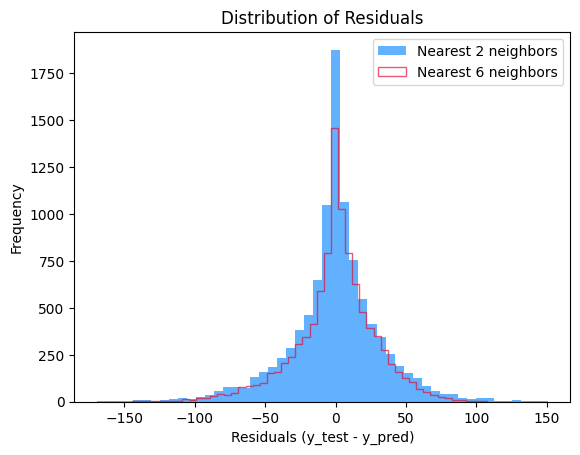

In [87]:
plt.hist(y_test-knn_pred, bins=50, color='dodgerblue', alpha=0.7, label='Nearest 2 neighbors', histtype='stepfilled');
plt.hist(y_test-knn_pred2, bins=50, color='crimson', alpha=0.7, label='Nearest 6 neighbors', histtype='step');
plt.legend()
plt.xlabel('Residuals (y_test - y_pred)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

Again, as expected, when you do not know the angle. Your predictions get really worse. Let's try to give the angle as a parameter as well. Now, it gets harder to visualize but think it this way, instead of looking at the 2 dimensional distances between points, now it looks at 3-dimensional distances also including the angle

In [88]:
########## Change is in here; we also pass the angle_deg feature
X_train, X_test, y_train, y_test = train_test_split(df_random[['a', 'b', 'angle_deg']], df_random['c'], test_size=0.2, random_state=42)
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(f"2K-NN Mean Squared Error (Random Angles): {mean_squared_error(y_test, knn_pred):.2f}")
print(f"2K-NN R^2 Score (Random Angles): {r2_score(y_test, knn_pred):.2f}")

knn2 = KNeighborsRegressor(n_neighbors=6)
knn2.fit(X_train, y_train)
knn_pred2 = knn2.predict(X_test)
print(f"6K-NN Mean Squared Error (Random Angles): {mean_squared_error(y_test, knn_pred2):.2f}")
print(f"6K-NN R^2 Score (Random Angles): {r2_score(y_test, knn_pred2):.2f}")


2K-NN Mean Squared Error (Random Angles): 1.62
2K-NN R^2 Score (Random Angles): 1.00
6K-NN Mean Squared Error (Random Angles): 1.05
6K-NN R^2 Score (Random Angles): 1.00


Text(0.5, 1.0, 'Distribution of Residuals')

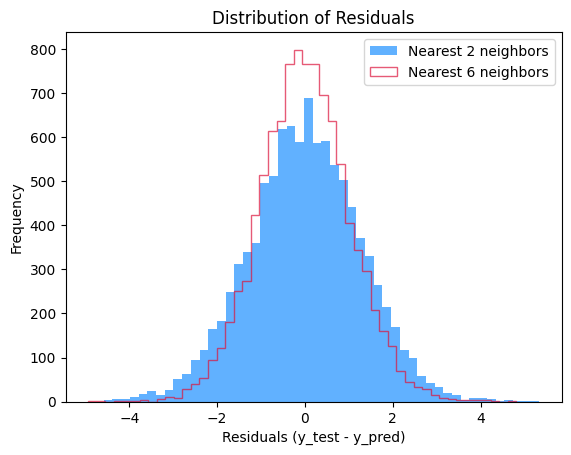

In [89]:
plt.hist(y_test-knn_pred, bins=50, color='dodgerblue', alpha=0.7, label='Nearest 2 neighbors', histtype='stepfilled');
plt.hist(y_test-knn_pred2, bins=50, color='crimson', alpha=0.7, label='Nearest 6 neighbors', histtype='step');
plt.legend()
plt.xlabel('Residuals (y_test - y_pred)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

And Voila. Now it does a better job. Below, I just try to visualize how the distance is measured in 3D.

In [95]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors


def visualize_knn_neighbors_3d(df, query_index=0, k=3):
    """
    Visualizes the triangle space in 3D (a, b, angle_deg), using c as marker size.
    Highlights one query point and its k nearest neighbors.
    
    Parameters:
    - df: DataFrame with columns a, b, angle_deg, c
    - query_index: index of the test point to highlight
    - k: number of neighbors to connect
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Feature space
    coords = df[["a", "b", "angle_deg"]].values
    c_vals = df["c"].values

    # Choose a test point (can be from another set)
    query_point = coords[query_index].reshape(1, -1)

    # Fit NearestNeighbors on the data
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(coords)
    distances, indices = nn.kneighbors(query_point)

    # Plot all points
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
               s=c_vals * 10, alpha=0.2, color="blue", label="Training data")

    # Plot query point
    ax.scatter(query_point[:, 0], query_point[:, 1], query_point[:, 2],
               s=100, color="red", label="Query point")

    # Connect to neighbors
    for i in indices[0]:
        neighbor = coords[i]
        ax.plot([query_point[0, 0], neighbor[0]],
                [query_point[0, 1], neighbor[1]],
                [query_point[0, 2], neighbor[2]],
                color="gray", linestyle="--", linewidth=1)

    # Labels
    ax.set_xlabel("Side a")
    ax.set_ylabel("Side b")
    ax.set_zlabel("Angle (°)")
    ax.set_title(f"{k}-Nearest Neighbors in Triangle Space")
    ax.legend()
    plt.tight_layout()
    plt.show()


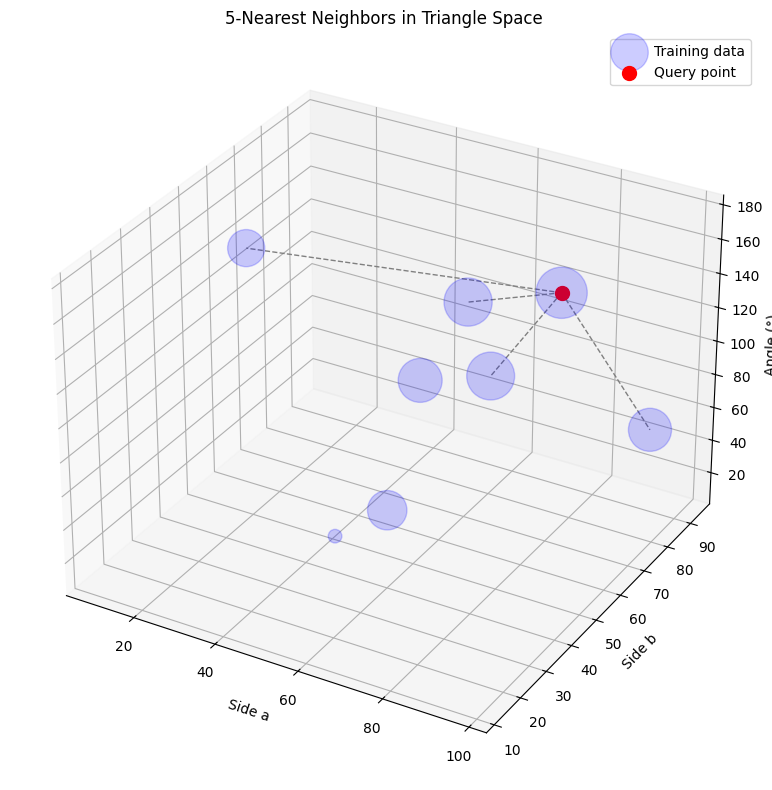

In [99]:
_df = generate_triangle_data(8, angle_mode='random')
visualize_knn_neighbors_3d(_df, query_index=3, k=5)